In [1]:
using DataFrames
using Chemfiles
using Gadfly
using Cairo
using Compose
set_default_plot_size(40cm, 14cm)

home = "/home/german/labo/18/egfr/rg/"
home_gram = "/home/german/labo/18/egfr/renonmis_gram/"
home_modos = "/home/german/labo/18/egfr/modos/"
home_rtdos = "/home/german/labo/18/egfr/rtdos_log/"
aa = 277

277

In [2]:
function tognm(vtor_anm)
    vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

tognm (generic function with 1 method)

In [3]:
function WeightedHist(in_vec, in_bins, in_weight, density = false)
    # Safety check    
    if length(in_vec) != length(in_weight)
        println("Each element of the input vector needs one weight")
        return
    end
    
    # Prepare variables
    out_counts = Array{Float64}(length(in_bins)-1)
    
    # Get weighted histogram
    for i=1:length(in_bins)-1
        if i == 1
            # Include those that fall before the beggining of the bins
            temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1]) .| (in_vec .<= in_bins[i])
            out_counts[i] = sum(in_weight[temp_bool])
        elseif i == length(in_bins)-1
            # Include those that fall after the end of the bins
            temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1]) .| (in_vec .>= in_bins[end])
            out_counts[i] = sum(in_weight[temp_bool])
        else
            temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1])
            out_counts[i] = sum(in_weight[temp_bool])
        end
    end
    
    # Get bins middle points
    out_middle = (in_bins[1:end-1] + in_bins[2:end]) / 2
    
    # Turn counts into density
    if (density == true)
        out_counts = out_counts ./ sum(out_counts) 
    end
    return out_counts, out_middle
end

WeightedHist (generic function with 2 methods)

# Rg

In [4]:
# Leo nombres de structuras
tmp = readdlm(string(home_gram, "pdbs.list"))
pdbs_list = convert(Array{String, 1}, reshape(tmp, length(tmp)));
aa = 277
aa_3 = aa * 3
aa_36 = aa_3 - 6
structs = length(pdbs_list)

# Leo activas e inactivas
tmp = readdlm(string(home_gram, "am.list"))
am_list = convert(Array{String, 1}, reshape(tmp, length(tmp)));

tmp = readdlm(string(home_gram, "im.list"))
im_list = convert(Array{String, 1}, reshape(tmp, length(tmp)));

In [33]:
# Leo radios de giro
tmp = readdlm(string(home, "rad_im"))
rad_im = reshape(tmp, length(tmp))

tmp = readdlm(string(home, "rad_im_vec1_mas"))
rad_im_vec1_mas = reshape(tmp, length(tmp))

tmp = readdlm(string(home, "rad_im_vec1_men"))
rad_im_vec1_men = reshape(tmp, length(tmp))

tmp = readdlm(string(home, "rad_im_vec2_mas"))
rad_im_vec2_mas = reshape(tmp, length(tmp))

tmp = readdlm(string(home, "rad_im_vec2_men"))
rad_im_vec2_men = reshape(tmp, length(tmp))

tmp = readdlm(string(home, "rad_am_vec1_mas"))
rad_am_vec1_mas = reshape(tmp, length(tmp))

tmp = readdlm(string(home, "rad_am_vec1_men"))
rad_am_vec1_men = reshape(tmp, length(tmp))

tmp = readdlm(string(home, "rad_am_vec2_mas"))
rad_am_vec2_mas = reshape(tmp, length(tmp))

tmp = readdlm(string(home, "rad_am_vec2_men"))
rad_am_vec2_men = reshape(tmp, length(tmp))

# Obtengo los deltas
der_im_vec1 = abs.(rad_im_vec1_mas - rad_im_vec1_men)
der_im_vec2 = abs.(rad_im_vec2_mas - rad_im_vec2_men)

der_am_vec1 = abs.(rad_am_vec1_mas - rad_am_vec1_men)
der_am_vec2 = abs.(rad_am_vec2_mas - rad_am_vec2_men);

## Grafico

In [41]:
# Vec 1
hbins = collect(minimum(der_im_vec1):0.005:maximum(der_am_vec1))
hweights_im = repeat([1.0], inner = [length(der_im_vec1)])
hweights_am = repeat([1.0], inner = [length(der_am_vec1)])

counts_im, bins = WeightedHist(der_im_vec1, hbins, hweights_im, true)
counts_am, bins = WeightedHist(der_am_vec1, hbins, hweights_am, true)


df_hist_der_vec1 = DataFrame(Probability = [counts_am ; counts_im],
    ΔRg = [ bins ; bins ],
    Conformer = repeat(["AM" ; "IM"], inner = [ length(bins)]));

# Vec 2
hbins = collect(minimum(der_im_vec2):0.005:maximum(der_am_vec2))
hweights_im = repeat([1.0], inner = [length(der_im_vec2)])
hweights_am = repeat([1.0], inner = [length(der_am_vec2)])

counts_im, bins = WeightedHist(der_im_vec2, hbins, hweights_im, true)
counts_am, bins = WeightedHist(der_am_vec2, hbins, hweights_am, true)


df_hist_der_vec2 = DataFrame(Probability = [counts_am ; counts_im],
    ΔRg = [ bins ; bins ],
    Conformer = repeat(["AM" ; "IM"], inner = [ length(bins)]));

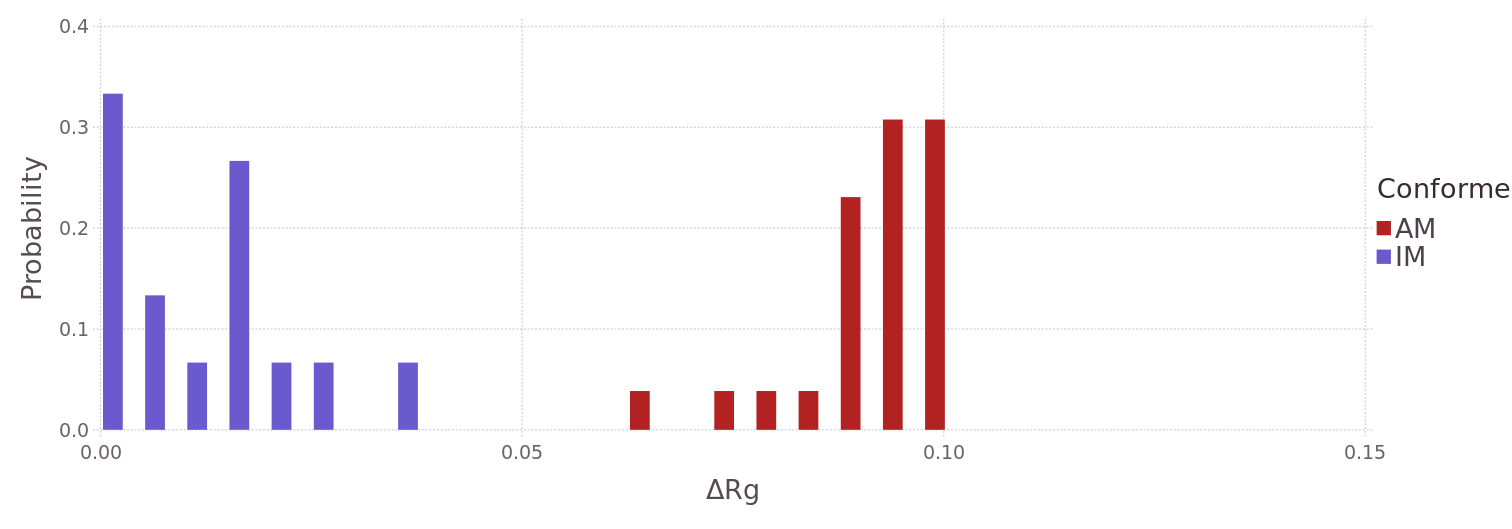

In [42]:
pdf_hist_der_vec1 = plot(df_hist_der_vec1, x="ΔRg", y="Probability", color = "Conformer", 
    Geom.bar(position = :dodge),

    #Guide.title("Figure 2.AA"),
    #Guide.ylabel("δV * Probability", orientation=:vertical), 
    #Guide.yticks(ticks = collect(0.25:0.25:1.0)),
    #Coord.cartesian(xmin = 0, xmax = 15),
    Scale.color_discrete_manual("Firebrick","SlateBlue"),


    Theme(bar_spacing = 2pt, grid_line_width=1pt, key_label_font_size = 20pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

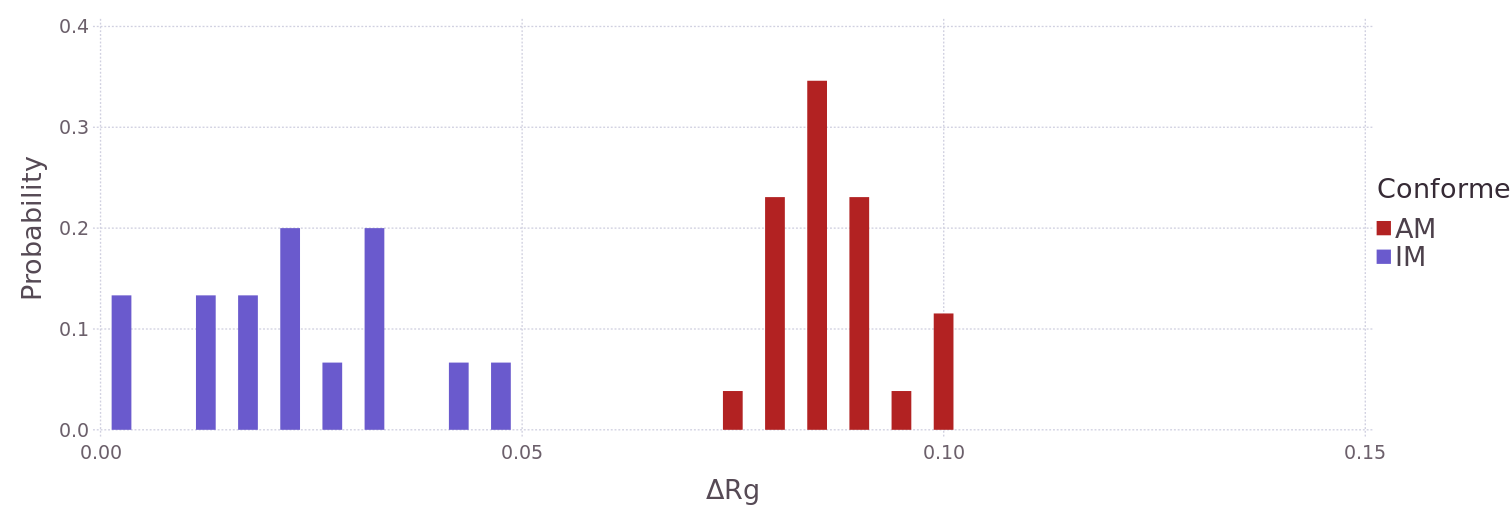

In [43]:
pdf_hist_der_vec2 = plot(df_hist_der_vec2, x="ΔRg", y="Probability", color = "Conformer", 
    Geom.bar(position = :dodge),

    #Guide.title("Figure 2.AA"),
    #Guide.ylabel("δV * Probability", orientation=:vertical), 
    #Guide.yticks(ticks = collect(0.25:0.25:1.0)),
    #Coord.cartesian(xmin = 0, xmax = 15),
    Scale.color_discrete_manual("Firebrick","SlateBlue"),


    Theme(bar_spacing = 2pt, grid_line_width=1pt, key_label_font_size = 20pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

## Guardo resultados

In [46]:
writedlm(string(home_rtdos, "rg_im_vec1"), der_im_vec1)
writedlm(string(home_rtdos, "rg_im_vec2"), der_im_vec2)

writedlm(string(home_rtdos, "rg_am_vec1"), der_am_vec1)
writedlm(string(home_rtdos, "rg_am_vec2"), der_am_vec2)